In [1]:
import votekit.ballot_generator as bg
from votekit.plots import plot_MDS, compute_MDS
from votekit.metrics import lp_dist
from votekit.graphs import BallotGraph
from votekit import Ballot, PreferenceProfile
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import itertools
import networkx as nx
import numpy as np
import ot
from itertools import zip_longest

In [2]:
def extend_ballots(pp: PreferenceProfile, num_cands:int):
    """
    Turn ballots of max length-1 into ballots of max length.
    Assumes no ties.

    Args:
        pp (PrefProfile): profile
        num_cands (int): total number of candidates, ie max ballot length

    Returns: 
        PreferenceProfile
    
    """

    # identify n-1 ballots with n
    new_ballots = [Ballot() for _ in range(pp.num_ballots)]

    for i, ballot in enumerate(pp.ballots):
        for s in ballot.ranking:
            if len(s) >1:
                raise TypeError("Ballots must have no ties.")
            
        if len(ballot.ranking) == num_cands-1:
            ballot_cands = [c for s in ballot.ranking for c in s]
            missing_cand = set(pp.candidates).difference(ballot_cands)
            new_ranking = ballot.ranking +(missing_cand,)

            new_ballots[i] = Ballot(ranking = new_ranking, weight = ballot.weight)


        else:
            new_ballots[i] = ballot

    return PreferenceProfile(ballots = new_ballots, candidates = pp.candidates).condense_ballots()


### Peter slate EMD code

In [3]:
def slate_detect_adj(s1: tuple, s2: tuple, n_cands: int) -> bool:
    """
    Determines if two rankings are adjacent in the slate ballot graph.

    Two nodes in the slate graph are considered adjacent if one of the following conditions is met:
        1. The two rankings vary by a swap (e.g., (A,A,B,B) and (A,B,A,B))
        2. The two, non-full rankings vary by a deletion (e.g., (A,A,B,) and (A,A) but not
            (A,A,B) and (A,A,B,B))
        3. One full ranking varies form another ranking by 2 deletions (e.g., (A,A,B,B) and
            (A,A,))
        4. The rankings are not identical (no self-loops)
            i. A full ranking is considered identical to a ranking of length n_cands - 1 if the
                rankings are equivalent when truncated (e.g. the rankings (A,A,B,B) and (A,A,B) are
                identical in a 4-candidate election with 2 candidates per slate)

    Args:
        s1 (tuple): First ranking.
        s2 (tuple): Second ranking.
        n_cands (int): Number of candidates in the election.

    Returns:
        bool: True if the rankings are adjacent in the slate ballot graph, False otherwise.

    Raises:
        ValueError: If the rankings are not tuples.
        ValueError: If the rankings vary by a single deletion and one of the rankings is a
            full ranking. The ranking missing a candidate is equivalent to the full ranking
            and should not have been passed to this function.
    """

    if not isinstance(s1, tuple) or not isinstance(s2, tuple):
        raise ValueError("s1 and s2 must be tuples")

    if s1 == s2:
        return False  # Not adjacent. Identical slates

    if abs(len(s1) - len(s2)) == 1:
        if len(s1) == n_cands or len(s2) == n_cands:
            raise ValueError(
                f"Invalid node for ballot graph with {n_cands} candidates. Found {s1} and {s2}. "
                f"All rankings in the ballot graph must be of length exactly {n_cands} "
                f"or of length <= {n_cands - 2}"
            )

        return s1 == s2[:-1] or s2 == s1[:-1]

    if abs(len(s1) - len(s2)) == 2 and (len(s1) == n_cands or len(s2) == n_cands):
        if len(s1) < len(s2):
            return s1 == s2[:-2]

        return s2 == s1[:-2]

    if len(s1) != len(s2):
        return False

    for i in range(len(s1) - 1):
        tmp = list(s1)
        tmp[i], tmp[i + 1] = tmp[i + 1], tmp[i]
        if tuple(tmp) == s2:
            return True

    return False


def slate_graph(slate_dict: dict) -> nx.Graph:
    """
    Creates a graph from a dictionary of slates. For example, if the slate dictionary
    is of the form {'A': ['X', 'Y'], 'B': ['Z', 'W']}, the a node in the full ballot graph
    labeled (X,Y,Z,W) will be mapped to the node labeled (A,A,B,B) in the slate graph.


    Two nodes in the slate graph are considered adjacent if one of the following conditions is met:
        1. The two rankings vary by a swap (e.g., (A,A,B,B) and (A,B,A,B))
        2. The two, non-full rankings vary by a deletion (e.g., (A,A,B,) and (A,A) but not
            (A,A,B) and (A,A,B,B))
        3. One full ranking varies form another ranking by 2 deletions (e.g., (A,A,B,B) and
            (A,A,) when there are 4 candidates)
        4. The rankings are not identical (no self-loops)
            i. A full ranking is considered identical to a ranking of length n_cands - 1 if the
                rankings are equivalent when truncated (e.g., (A,A,B,B) and (A,A,B) are identical
                in a 4-candidate election with 2 candidates per slate)

    Note:
        The graph will not contain any nodes labeled with rankings of length n_cands - 1, where
        n_cands is the number of candidates in the election. These nodes are equivalent to
        full rankings (e.g. (A,A,B,B) is equivalent to (A,A,B) in a 4-candidate election with 2
        candidates per slate), and so any node ballot missing a candidate has their weight
        allocated to the corresponding full ranking.

    Args:
        slate_dict (dict): Dictionary of slates of candidates where the keys are slate names
            and the values are lists of candidates.

    Returns:
        nx.Graph: The slate ballot graph for the given slate dictionary.
    """

    graph = nx.Graph()

    slate_tup = tuple(
        y for lst in [[c] * len(slate_dict[c]) for c in slate_dict] for y in lst
    )

    powerset = set(
        itertools.chain.from_iterable(
            itertools.permutations(slate_tup, r)
            for r in list(set(range(1, len(slate_tup) + 1)) - set({len(slate_tup) - 1}))
        )
    )

    graph.add_nodes_from(powerset)

    n_cands = len(slate_tup)

    for a, b in itertools.combinations(graph.nodes, 2):
        if slate_detect_adj(a, b, n_cands):
            graph.add_edge(a, b)

    if not nx.is_connected(graph):
        raise ValueError("Graph is not connected")

    return graph


def ballot_to_slate_tuple(
    ballot: Ballot, slate_dict: dict[str, list[str]], n_cands: int
) -> tuple:
    """
    Converts a full ranking ballot to a slate tuple. For example, if the ballot is
    (B_0, B_1, A_0, B_2, A_1), the slate dictionary is
    {'A': ['A_0', 'A_1'], 'B': ['B_0', 'B_1', 'B_2']}, then the slate tuple would be
    (B, B, A, B, A).

    Args:
        ballot (Ballot): Full ranking ballot.
        slate_dict (dict): Dictionary of slates of candidates where the keys are slate names
            and the values are lists of candidates.
        n_cands (int): Number of candidates in the election.

    Returns:
        tuple: Slate tuple corresponding to the inputted ballot.
    """
    # since only one cand, treats them as a string not a list heres
    inverted_slate_dict = {frozenset({x}): k for k, v in slate_dict.items() for x in v}
    new_slate_tup = tuple(
        [inverted_slate_dict[frozenset({x})] for r in ballot.ranking for x in r]
    )

    if len(new_slate_tup) == n_cands - 1:
        cand_counts = {slate: 0 for slate in slate_dict}
        for cand in new_slate_tup:
            cand_counts[cand] += 1

        for slate, lst in slate_dict.items():
            if cand_counts[slate] != len(lst):
                return (*new_slate_tup, slate)

    return new_slate_tup


def ranking_to_slate_tuple(
    ranking: tuple, slate_dict: dict[str, list[str]], n_cands: int
) -> tuple:
    """
    Converts a full ranking tuple to a slate tuple. For example, if the ballot is
    (B_0, B_1, A_0, B_2, A_1), the slate dictionary is
    {'A': ['A_0', 'A_1'], 'B': ['B_0', 'B_1', 'B_2']}, then the slate tuple would be
    (B, B, A, B, A).

    Args:
        ranking (tuple): Full ranking of candidates.
        slate_dict (dict): Dictionary of slates of candidates where the keys are slate names
            and the values are lists of candidates.
        n_cands (int): Number of candidates in the election.

    Returns:
        tuple: Slate tuple corresponding to the inputted ballot.
    """

    inverted_slate_dict = {x: k for k, v in slate_dict.items() for x in v}

    new_slate_tup = tuple([inverted_slate_dict[x] for x in ranking])

    if len(new_slate_tup) == n_cands - 1:
        cand_counts = {slate: 0 for slate in slate_dict.keys()}
        for cand in new_slate_tup:
            cand_counts[cand] += 1

        for slate, lst in slate_dict.items():
            if cand_counts[slate] != len(lst):
                return (*new_slate_tup, slate)

    return new_slate_tup


def score_vec_from_slate_tuple(
    slate_tuple: tuple, slate_dict: dict, n_cands: int, key_ordering: list = None
) -> list:
    """
    Computes the score vector for a given slate tuple. The score vector is determined
    by the ordering of the candidates in the slate dictionary, so if the slate dictionary
    is of the form {'A': ['A_0', 'A_1'], 'B': ['B_0', 'B_1', 'B_2']}, the coordinate of the score
    vector would have coordinates (A_0, A_1, B_0, B_1, B_2).

    The score vector is determined by the ranking of the candidates in a given ballot. For example,
    if the ballot is (B_0, B_1, A_0, B_2, A_1), the score vector would be (3, 1, 5, 4, 2). In the
    event of a short ballot, the remaining points are distributed evenly between the candidates.
    So if the ballot is (B_0, B_1, A_0), the score vector would be (3, 1.5, 5, 4, 1.5) since of
    the 15 points in the ballot, 3 are unallocated and are assumed to be evenly distributed between
    the unlisted candidates.


    Args:
        slate_tuple (tuple): A ranking converted into slates. For example, if the ballot is
            (B_0, B_1, A_0, B_2, A_1), the slate dictionary is
            {'A': ['A_0', 'A_1'], 'B': ['B_0', 'B_1', 'B_2']}, then the slate tuple would be
            (B, B, A, B, A).

        slate_dict (dict): Dictionary of slates of candidates where the keys are slate names
            and the values are lists of candidates.

        n_cands (int): Number of candidates in the election.

        key_ordering (list): List of candidate names in the order they should be arranged in the
            score vector. If None, the candidates are arranged in the order of the keys in the
            slate dictionary.

    Returns:
        numpy.array: Score vector for the inputted slate tuple.

    Raises:
        ValueError: If the the passed key ordering is not None and does not have the same
            elements as the slate dictionary keys.
    """

    is_slate_tuple = True
    for item in slate_tuple:
        if item not in slate_dict.keys():
            is_slate_tuple = False
            break

    if not is_slate_tuple:
        slate_tuple = ranking_to_slate_tuple(
            ranking=slate_tuple, slate_dict=slate_dict, n_cands=n_cands
        )

    score_vec = []
    max_score = sum(len(slate_dict[c]) for c in slate_dict)
    n_cands = sum([len(slate_dict[c]) for c in slate_dict])

    score_dict = {k: [] for k in slate_dict}
    for i, s in enumerate(slate_tuple):
        score_dict[s].append(max_score - i)

    total_cands_scored = len(slate_tuple)
    if total_cands_scored < n_cands:
        n = max_score - total_cands_scored

        avg_remaining = (n + 1) / 2  # ((n*(n+1))/2)/n
        for key, dct in score_dict.items():
            if len(dct) < len(slate_dict[key]):
                dct.extend([avg_remaining] * (len(slate_dict[key]) - len(dct)))

    if key_ordering is not None:
        if set(key_ordering) != set(slate_dict.keys()):
            raise ValueError(
                f"Key ordering elements {key_ordering} differ from the slate dictionary "
                f"keys {list(slate_dict.keys())}"
            )

        for key in key_ordering:
            score_vec.extend(score_dict[key])
    else:
        for v in score_dict.values():
            score_vec.extend(v)

    return np.array(score_vec)


def slate_earth_mover_dist(
    pp1: PreferenceProfile, pp2: PreferenceProfile, slate_dict: dict
) -> int:
    """
    Computes the earth mover distance between two profiles.
    Assumes both profiles share the same candidates.

    Args:
        pp1 (PreferenceProfile): ``PreferenceProfile`` for first election.
        pp2 (PreferenceProfile): ``PreferenceProfile`` for second election.
        slate_dict

    Returns:
        int: Earth mover distance between inputted profiles.
    """

    n_cands = sum(len(v) for v in slate_dict.values())

    ballot_graph = slate_graph(slate_dict)

    for n1, n2, attr in ballot_graph.edges(data=True):
        n1_scores = score_vec_from_slate_tuple(n1, slate_dict, n_cands)
        n2_scores = score_vec_from_slate_tuple(n2, slate_dict, n_cands)

        assert (
            n1_scores.ndim == 1 and n2_scores.ndim == 1
        ), "Score vectors returned from `score_vec_from_slate_tuple` must be 1D to be used in EMD"

        attr["weight"] = float(0.5 * np.linalg.norm(n1_scores - n2_scores, ord=1))
        ballot_graph.nodes[n1]["mass1"] = 0
        ballot_graph.nodes[n2]["mass1"] = 0
        ballot_graph.nodes[n1]["mass2"] = 0
        ballot_graph.nodes[n2]["mass2"] = 0

    dist_mat = nx.floyd_warshall_numpy(ballot_graph, weight="weight")

    total_mass1 = 0
    total_mass2 = 0
    for ballot1, ballot2 in zip_longest(pp1.ballots, pp2.ballots, fillvalue=None):
        if ballot1 is not None and ballot2 is not None:
            node1 = ballot_to_slate_tuple(ballot1, slate_dict, n_cands)
            node2 = ballot_to_slate_tuple(ballot2, slate_dict, n_cands)
            ballot_graph.nodes[node1]["mass1"] += ballot1.weight
            ballot_graph.nodes[node2]["mass2"] += ballot2.weight
            total_mass1 += ballot1.weight
            total_mass2 += ballot2.weight
        elif ballot1 is None and ballot2 is not None:
            node = ballot_to_slate_tuple(ballot2, slate_dict, n_cands)
            ballot_graph.nodes[node]["mass2"] += ballot2.weight
            total_mass2 += ballot2.weight
        else:
            node = ballot_to_slate_tuple(ballot1, slate_dict, n_cands)
            ballot_graph.nodes[node]["mass1"] += ballot1.weight
            total_mass1 += ballot1.weight

    for node, attr in ballot_graph.nodes(data=True):
        attr["mass1"] = attr["mass1"] / total_mass1
        attr["mass2"] = attr["mass2"] / total_mass2

    em_arr1 = np.array(
        [float(attr["mass1"]) for _, attr in ballot_graph.nodes(data=True)]
    )
    em_arr2 = np.array(
        [float(attr["mass2"]) for _, attr in ballot_graph.nodes(data=True)]
    )

    return np.sum(np.multiply(dist_mat, ot.emd(em_arr1, em_arr2, dist_mat)))


In [4]:
# constants

pref_scenario_settings = {"U": {"A":2, "B":2 }, 
                          "X":{"A":2, "B":1/2 },
                            "Y":{"A":1/2, "B":2 },
                              "S":{"A":1/2, "B":1/2 }}

pref_scenario_markers = {"U": "$\mathdefault{U}$", 
                          "X":"$\mathdefault{X}$",
                            "Y":"$\mathdefault{Y}$",
                              "S":"$\mathdefault{S}$"}

pref_scenarios = list(pref_scenario_settings.keys())
cand_per_slate = 3
num_profiles = 5
num_ballots = 1000
b_coh_list  = [.75]
bloc_voter_prop = {"A":0, "B": 1}
slate_to_candidates = {"A": [f"A_{i}" for i in range(cand_per_slate)],
                       "B": [f"B_{i}" for i in range(cand_per_slate)]}
model_to_color = {'CS-C': '#D2691E', 'CS-W': '#E32636', 's-BT': '#FFBF00', 's-PL': '#8DB600'}
models = list(model_to_color.keys())
profile_dict = {(m, s, b_coh) :[] for m in models for s in pref_scenarios for b_coh in b_coh_list}


emd_slate_to_candidates = {c: [c] for c_list in slate_to_candidates.values() for c in c_list}

In [5]:
# generate profiles

for pref_scenario_str, b_alphas in pref_scenario_settings.items():
    for model in models:
        for b_coh in b_coh_list:
            if model == "CS-C":
                g = bg.CambridgeSampler.from_params(slate_to_candidates=slate_to_candidates,
                        bloc_voter_prop=bloc_voter_prop,
                        cohesion_parameters={"A": {"A": 1, "B": 0},
                                             "B": {"A":1-b_coh, "B":b_coh}},
                        alphas={"A": {"A":1, "B":1},
                                "B": b_alphas},
                        W_bloc = "A",
                        C_bloc = "B")

            elif model == "CS-W":
                g = bg.CambridgeSampler.from_params(slate_to_candidates=slate_to_candidates,
                        bloc_voter_prop=bloc_voter_prop,
                        cohesion_parameters={"A": {"A": 1, "B": 0},
                                             "B": {"A":1-b_coh, "B":b_coh}},
                        alphas={"A": {"A":1, "B":1},
                                "B": b_alphas},
                        W_bloc = "B",
                        C_bloc = "A")
            
            elif model == "s-BT":
                g = bg.slate_BradleyTerry.from_params(slate_to_candidates=slate_to_candidates,
                        bloc_voter_prop=bloc_voter_prop,
                        cohesion_parameters={"A": {"A": 1, "B": 0},
                                             "B": {"A":1-b_coh, "B":b_coh}},
                        alphas={"A": {"A":1, "B":1},
                                "B": b_alphas},)

            elif model == "s-PL":
                g = bg.slate_PlackettLuce.from_params(slate_to_candidates=slate_to_candidates,
                        bloc_voter_prop=bloc_voter_prop,
                        cohesion_parameters={"A": {"A": 1, "B": 0},
                                             "B": {"A":1-b_coh, "B":b_coh}},
                        alphas={"A": {"A":1, "B":1},
                                "B": b_alphas},)

            else:
                raise ValueError("invalid generator")
            
        
            
                
            profile_dict[(model, pref_scenario_str, b_coh)] = [extend_ballots(pp= g.generate_profile(num_ballots), num_cands = 2*cand_per_slate) for _ in range(num_profiles)]



In [6]:
b_coh = .75
coord_dict_l1 = compute_MDS(data = {k:v for k,v in profile_dict.items() if k[2]==b_coh},
            distance = lp_dist, # default is p=1
            )

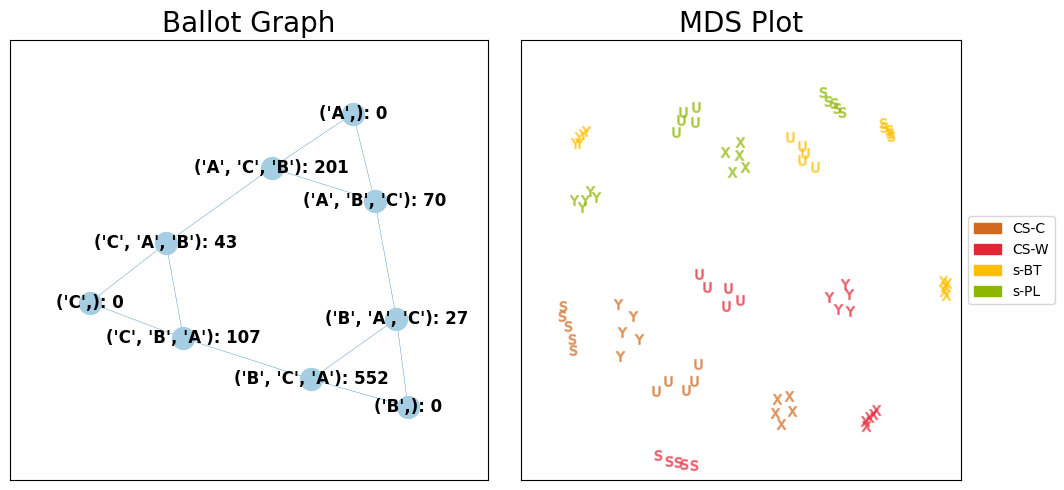

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plot_MDS(coord_dict=coord_dict_l1,
                  ax = axes[1],
                plot_kwarg_dict={(model, pref_scenario, b_coh): {"c": model_to_color[model], "s":50, "marker":pref_scenario_markers[pref_scenario], "alpha" :.5} 
                                            for model in models for pref_scenario in pref_scenarios},
                legend = False, title = False)




candidates  = ["A", "B", "C"]
iac = bg.ImpartialAnonymousCulture(candidates = candidates)
profile = iac.generate_profile(number_of_ballots= 1000)
ballot_graph = BallotGraph(profile)
ballot_graph.draw(labels= True,show_cast=False, ax = axes[0], scale = .25)

axes[0].set_title("Ballot Graph",fontsize=20)
axes[1].set_title("MDS Plot",fontsize=20)
# Create a list of patches for the legend
patches = [mpatches.Patch(color=color, label=label) for label, color in model_to_color.items()]
plt.tight_layout()
plt.legend(handles=patches, loc='center left', bbox_to_anchor=(1, 1/2))
plt.savefig("../fig_2.png", dpi=300, bbox_inches = "tight")
